# Task: develop a model that predicts whether a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes about the cell. 

## Get data from url

1. Sample code number: id number
2. Clump Thickness: 1 - 10
3. Uniformity of Cell Size: 1 - 10
4. Uniformity of Cell Shape: 1 - 10
5. Marginal Adhesion: 1 - 10
6. Single Epithelial Cell Size: 1 - 10
7. Bare Nuclei: 1 - 10
8. Bland Chromatin: 1 - 10
9. Normal Nucleoli: 1 - 10
10. Mitoses: 1 - 10
11. Class: (2 for benign, 4 for malignant)

In [40]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"

In [163]:
from urllib.request import urlopen

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import pandas as pd
import numpy as np
import time

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing


from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.cross_validation import train_test_split

%matplotlib inline
sns.set(style="white")

In [42]:
content = urlopen(url)

In [43]:
df_headers = ['code','clump_thickness','size_uniformity','shape_uniformity','marginal_adhesion','single_cell_size',
             'bare_nuclei','bland_chromatin','normal_nucleoli','mitoses','cell_class']

In [44]:
df = pd.read_csv(content, header = None, names = df_headers, na_values='?', index_col=0)
df.head()

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,single_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,cell_class
code,,,,,,,,,,
1000025,5,1,1,1,2,1.0,3,1,1,2
1002945,5,4,4,5,7,10.0,3,2,1,2
1015425,3,1,1,1,2,2.0,3,1,1,2
1016277,6,8,8,1,3,4.0,3,7,1,2
1017023,4,1,1,3,2,1.0,3,1,1,2


## summary level data

In [45]:
## data shape?
df.shape

(699, 10)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 1000025 to 897471
Data columns (total 10 columns):
clump_thickness      699 non-null int64
size_uniformity      699 non-null int64
shape_uniformity     699 non-null int64
marginal_adhesion    699 non-null int64
single_cell_size     699 non-null int64
bare_nuclei          683 non-null float64
bland_chromatin      699 non-null int64
normal_nucleoli      699 non-null int64
mitoses              699 non-null int64
cell_class           699 non-null int64
dtypes: float64(1), int64(9)
memory usage: 60.1 KB


In [47]:
df.describe()

/home/cathy/miniconda3/envs/insight/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,single_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,cell_class
count,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,NaN,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,NaN,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,NaN,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [48]:
## how many samples are there per cell class?
## (2 for benign, 4 for malignant)
df.cell_class.value_counts()

2    458
4    241
Name: cell_class, dtype: int64

In [49]:
## percent benign
print(458/699)

## percent malignant
print(241/699)

0.6552217453505007
0.3447782546494993


In [120]:
## What cell classes to the rows with missing bare_nuclei correspond to?
missing_row_idxs = pd.isnull(df).any(1).nonzero()[0]
missing_row_idxs

array([ 23,  40, 139, 145, 158, 164, 235, 249, 275, 292, 294, 297, 315,
       321, 411, 617])

In [127]:
df.iloc[list(missing_row_idxs)]

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,single_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,cell_class
code,,,,,,,,,,
1057013,8,4,5,1,2,NaN,7,3,1,4
1096800,6,6,6,9,6,NaN,7,8,1,2
1183246,1,1,1,1,1,NaN,2,1,1,2
1184840,1,1,3,1,2,NaN,2,1,1,2
1193683,1,1,2,1,3,NaN,1,1,1,2
1197510,5,1,1,1,2,NaN,3,1,1,2
1241232,3,1,4,1,2,NaN,3,1,1,2
169356,3,1,1,1,2,NaN,3,1,1,2
432809,3,1,3,1,2,NaN,2,1,1,2


missing rows mostly correspond to benign cells

## Observations on missing `bare_nuclei` values:
- From correlation plots in visualization section, we can see bare nuclei is actually highly correlated with the outcome.  => make boxplots/histograms of bare_nuclei per class.
- later, possibly impute using stratified mean.
- because there are only a couple malignant cells missing bare_nuclei, we won't lose a lot of signal in our model by just dropping these rows in our initial model.

## Overall Observations 

- column 'bare_nuclei' is the only one with missing values (missing 16 values).
- the size of values in each column is on par with each other (all within the same range).  For all columns, max=10, min=1.  => don't need to standardize
- There are more benign cells than malignant cells, but the imbalance is not too bad, i.e. 34% malignant, 65% benign
- There are 9 attributes/features.

## Visualize raw data

### visualize distribution of each feature using boxplot

In [52]:
# first melt dataframe for input into seaborn

In [53]:
df_melt = pd.melt(df, var_name="attribute")

In [54]:
df_melt.head()

,attribute,value
0,clump_thickness,5.0
1,clump_thickness,5.0
2,clump_thickness,3.0
3,clump_thickness,6.0
4,clump_thickness,4.0


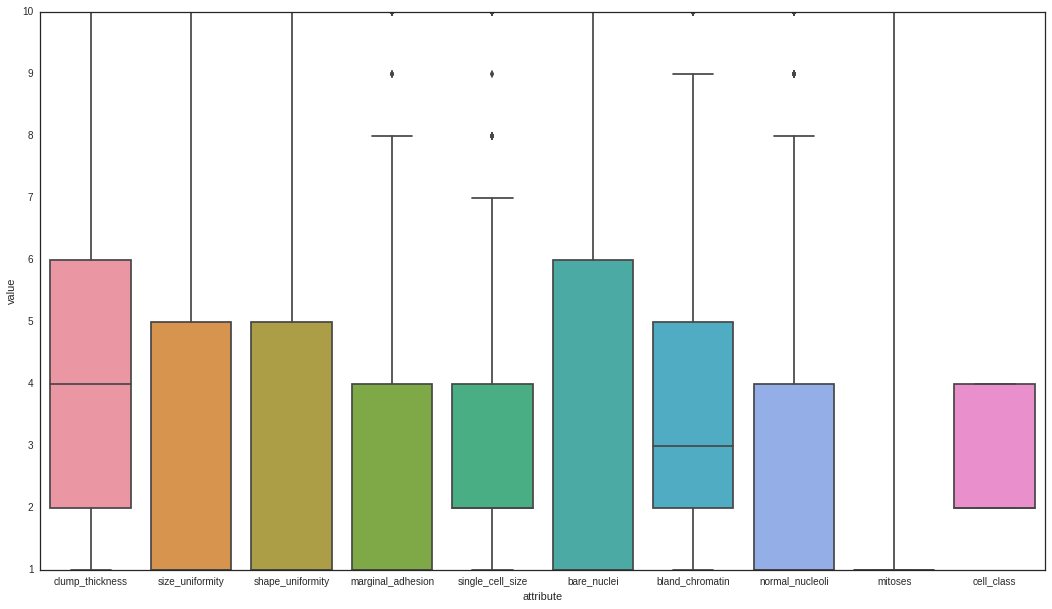

In [64]:
plt.rcParams['figure.figsize']=(18,10)
ax = sns.boxplot(x='attribute', y='value', data=df_melt)

### visualize with histograms

- e.g. from boxplot, attribute 'mitoses' looks uninformative.  Double check with a histogram of mitoses values

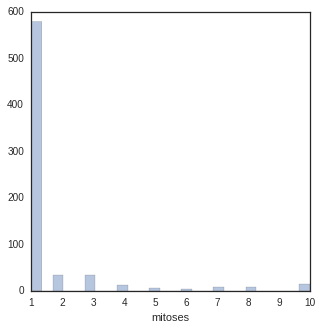

In [71]:
## mitoses
plt.rcParams['figure.figsize']=(5,5)
sns.distplot(df['mitoses'], kde=False)()

In [85]:
## Vast majority of mitoses values are equal to 1.  What class do values > 1 belong to?
df.query('mitoses > 1')['cell_class'].value_counts()

4    107
2     13
Name: cell_class, dtype: int64

In [87]:
## malignant cells are overrepresented in cells with mitoses values > 1. (flipped from overall class distribution, 
## where there are more benign cells than malignant cells)

## benign
print('benign percentage: ', 13/120)
## malignant
print('malignant percentage: ', 107/120)

benign percentage:  0.10833333333333334
malignant percentage:  0.8916666666666667


To enhance the signal from the mitoses attribute, we could convert it to a categorical variable `mitoses_greater_than_1`.

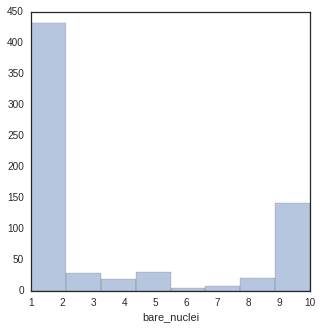

In [74]:
## bare nuclei
sns.distplot(df['bare_nuclei'].dropna(), kde=False)

[(0, 10)]

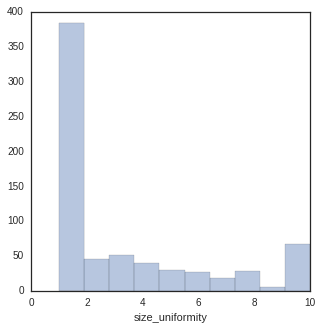

In [78]:
## size uniformity
ax = sns.distplot(df['size_uniformity'].dropna(), kde=False)
ax.set(xlim=(0,10))

[(0, 10)]

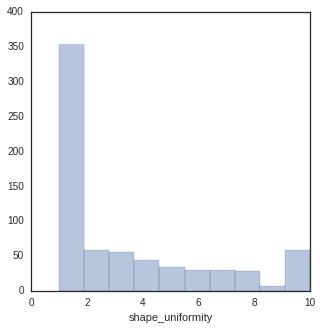

In [79]:
## shape uniformity
ax = sns.distplot(df['shape_uniformity'], kde=False)
ax.set(xlim=(0,10))

[(0, 10)]

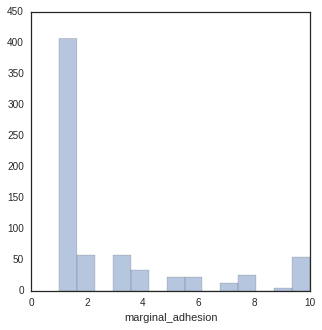

In [80]:
## marginal adhesion
ax = sns.distplot(df['marginal_adhesion'].dropna(), kde=False)
ax.set(xlim=(0,10))

### Many attributes could be heavily correlated, e.g. size and shape uniformity in particular.  Check this with a corrplot of pearson correlation coefficients.

In [81]:
corrmat = df.corr()

In [82]:
corrmat.shape

(10, 10)

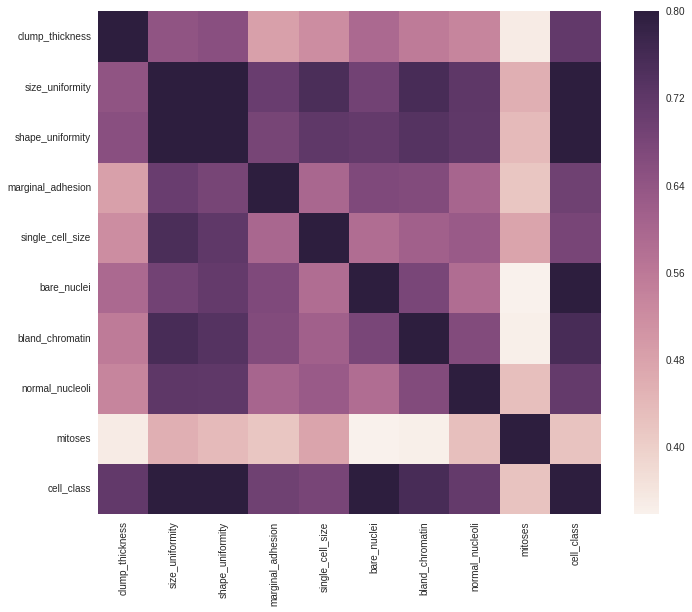

In [83]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)

### Correlations we observe:
- shape_uniformity and size_uniformity are heavily correlated (~ 0.8)
- the variable we are trying to predict, cell_class, is heavily correlated with size_uniformity, shape_uniformity, and bare_nuclei
- bare_nuclei is not heavily correlated with size_uniformity or shape_uniformity, although all 3 variables are heavily correlated with the outcome variable (cell_class).
- bare_nuclei and size_uniformity are also pretty highly correlated (> 0.65) with all the other attributes, except mitoses.

### Potential strategies
- keep only one of size_uniformity or shape_uniformity
- bare_nuclei is definitely an important feature
- consider training basic model using solely size_uniformity and bare_nuclei as 2 features
- if using all features (except dropping shape_uniformity), use regularization
- To enhance the signal from the mitoses attribute, we could convert it to a categorical variable `mitoses_greater_than_1`.

### Visualize with PCA
with more time, go back and color points by cell class

In [93]:
X_centered = preprocessing.scale(df.iloc[:,:9].dropna().as_matrix(), with_mean=True, with_std=False)
svd = TruncatedSVD(n_components=3, random_state=42)
X_reduced = svd.fit_transform(X_centered)
svd.explained_variance_ratio_

array([ 0.69050756,  0.07195066,  0.06055921])

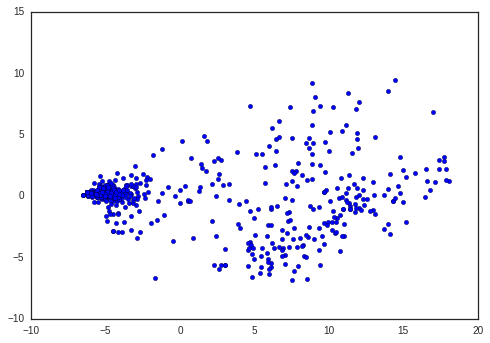

In [221]:
## pc1 & pc2
plt.scatter(X_reduced[:,0], X_reduced[:,1])

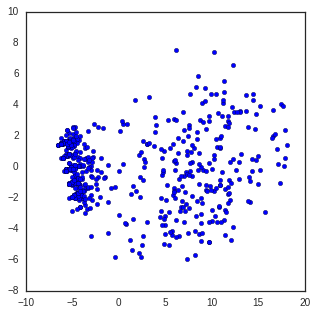

In [95]:
## pc1 & pc3
plt.scatter(X_reduced[:,0], X_reduced[:,2])

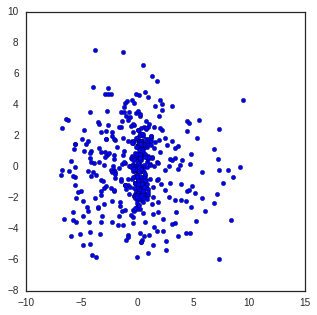

In [96]:
## pc2 & pc3
plt.scatter(X_reduced[:,1], X_reduced[:,2])

# Split data into train-val-test sets
Drop the 16 rows with missing bare_nuclei (mostly benign cells)

In [152]:
df_noNAs = df.dropna()
df_noNAs.shape

(683, 10)

# logistic regression with only 2 features:
- size_uniformity
- bare nuclei

In [153]:
## binarize outcome variable label
lb = preprocessing.LabelBinarizer()
labels = lb.fit_transform(df_noNAs['cell_class'])

In [154]:
print(labels[0:6])
print(df.iloc[0:6,9])

[[0]
 [0]
 [0]
 [0]
 [0]
 [1]]
code
1000025    2
1002945    2
1015425    2
1016277    2
1017023    2
1017122    4
Name: cell_class, dtype: int64


In the binarized label notation, benign <-> 0, malignant <-> 1

In [156]:
X_train, X_test, y_train, y_test = train_test_split(df_noNAs[['size_uniformity','bare_nuclei']].as_matrix(),
                                                    labels,
                                                    test_size=.2,
                                                    random_state=5435,
                                                    stratify=df_noNAs['cell_class'])

In [157]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((546, 2), (137, 2), (546, 1), (137, 1))

In [176]:
## cross-validation - optimize over precision, recall, or f1 score?
clf = LogisticRegressionCV(cv = 10, random_state=5435, scoring='f1')
tic = time.time()
clf.fit(X_train, y_train.ravel())
toc = time.time()

In [177]:
print('computed in {}s'.format(toc-tic))

computed in 0.317577600479126s


In [179]:
print ('best f1:', clf.scores_[1].max())

best f1: 1.0


In [180]:
## now evaluate model on test set
y_test_pred = clf.predict(X_test)

In [181]:
precision_recall_fscore_support(y_test, y_test_pred)

(array([ 0.96666667,  0.95744681]),
 array([ 0.97752809,  0.9375    ]),
 array([ 0.97206704,  0.94736842]),
 array([89, 48]))

In [193]:
confusion_matrix(y_test, y_test_pred)

array([[87,  2],
       [ 3, 45]])

In [232]:
## let's look at the coefficients
for i,val in enumerate(df_noNAs.drop('cell_class', axis=1)[['size_uniformity','bare_nuclei']].columns.values):
    print(val, ': ', clf.coef_[0][i])

size_uniformity :  0.96981295184
bare_nuclei :  0.570958942798


## as we expect, both size_uniformity and bare_nuclei have positive coefficients since they're both correlated with the outcome according to the heat map

## With only two features, 'size_uniformity' and 'bare_nuclei', in logistic regression we can get excellent, interpretable results.

For the malignant class:
- precision: .957
- recall: 0.9375
- fscore: 0.947

## For breast cancer biopsies, we are more concerned with getting all the malignant cells, so let's trying optimizing solely for recall now:

In [187]:
## cross-validation - optimize over precision, recall, or f1 score?
clf_recall = LogisticRegressionCV(cv = 10, random_state=5435, scoring='recall')
tic = time.time()
clf_recall.fit(X_train, y_train.ravel())
toc = time.time()

In [188]:
print ('best recall:', clf_recall.scores_[1].max())

best recall: 1.0


In [189]:
## now evaluate model on test set
y_test_pred = clf_recall.predict(X_test)

In [190]:
precision_recall_fscore_support(y_test, y_test_pred)

(array([ 0.96666667,  0.95744681]),
 array([ 0.97752809,  0.9375    ]),
 array([ 0.97206704,  0.94736842]),
 array([89, 48]))

In [194]:
## the results are the same as optimizing for f1 score (curiously...)

## Now, let's try logistic regression with more features
- all features except shape_uniformity
- engineer feature from mitoses => turn into categorical variable, where mitoses is either = 1 or > 1.

In [208]:
df_engineered = df_noNAs
df_engineered = (df_engineered.assign(mitoses_greater_than1 = lambda x: x.mitoses > 1).
                 drop('mitoses', axis=1).
                 drop('shape_uniformity', axis=1))
df_engineered.head()

,clump_thickness,size_uniformity,marginal_adhesion,single_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,cell_class,mitoses_greater_than1
code,,,,,,,,,
1000025,5,1,1,2,1.0,3,1,2,False
1002945,5,4,5,7,10.0,3,2,2,False
1015425,3,1,1,2,2.0,3,1,2,False
1016277,6,8,1,3,4.0,3,7,2,False
1017023,4,1,3,2,1.0,3,1,2,False


In [209]:
## turn mitoses_greater_than_1 into a binary variable rather than boolean
df_engineered['mitoses_greater_than1'] = df_engineered['mitoses_greater_than1'].astype(int)

### do logistic regression with this new data frame

In [215]:
X_train, X_test, y_train, y_test = train_test_split(df_engineered.drop('cell_class', axis=1).as_matrix(),
                                                    labels,
                                                    test_size=.2,
                                                    random_state=5435,
                                                    stratify=df_engineered['cell_class'])

In [216]:
## cross-validation - optimize over recall
clf_engineered = LogisticRegressionCV(cv = 10, random_state=5435, scoring='recall')
tic = time.time()
clf_engineered.fit(X_train, y_train.ravel())
toc = time.time()

In [217]:
print ('best recall:', clf_engineered.scores_[1].max())

best recall: 1.0


In [218]:
## now evaluate model on test set
y_test_pred = clf_engineered.predict(X_test)

In [219]:
precision_recall_fscore_support(y_test, y_test_pred)

(array([ 0.97727273,  0.93877551]),
 array([ 0.96629213,  0.95833333]),
 array([ 0.97175141,  0.94845361]),
 array([89, 48]))

For the malignant class, using logistic regression and including more features (including an engineered column):
- precision: 0.939
- recall: 0.958
- fscore: 0.948

The recall score has 2% improvement over the simple 2 variable model, which had recall=0.938.

In [230]:
## let's look at the coefficients
for i,val in enumerate(df_engineered.drop('cell_class', axis=1).columns.values):
    print(val, ': ', clf_engineered.coef_[0][i])

clump_thickness :  0.561179248515
size_uniformity :  0.280372870814
marginal_adhesion :  0.325092979792
single_cell_size :  0.0794916966025
bare_nuclei :  0.420232740344
bland_chromatin :  0.352349252127
normal_nucleoli :  0.216046258435
mitoses_greater_than1 :  0.429169154184


## Is this result statistically significant?

In [235]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
from sklearn.linear_model import LogisticRegression

In [242]:
logreg = LogisticRegression()
cv = StratifiedKFold(10)
X = df_engineered.drop('cell_class', axis=1).as_matrix()
y = labels.ravel()

In [243]:
score, permutation_scores, pvalue = permutation_test_score(
    logreg, X, y, scoring="recall", cv=cv, n_permutations=100, n_jobs=1)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

Classification score 0.9375 (pvalue : 0.00990099009901)


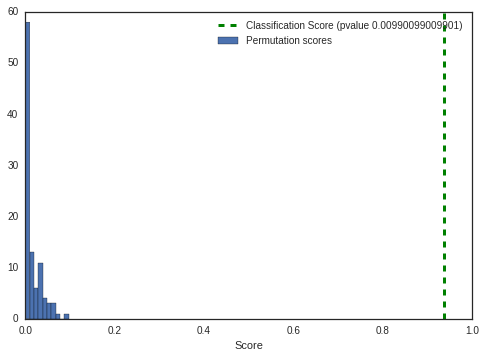

In [247]:
plt.hist(permutation_scores, 10, label='Permutation scores')
ylim = plt.ylim()
# BUG: vlines(..., linestyle='--') fails on older versions of matplotlib
#plt.vlines(score, ylim[0], ylim[1], linestyle='--',
#          color='g', linewidth=3, label='Classification Score'
#          ' (pvalue %s)' % pvalue)
#plt.vlines(1.0 / n_classes, ylim[0], ylim[1], linestyle='--',
#          color='k', linewidth=3, label='Luck')
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()

## clearly model does much better than random (p value = 0.0099)